<h1 style="color: #AA1358;">SUPERVISED REGRESSION</h1>

<h2 style="color: #6D183F;">Libraries</h2>

In [1]:
### 📚 Basic libraries
import pandas as pd # data manipulation
import numpy as np # funciones matemáticas

#❗New Libraries !
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

In [2]:
# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

!pip install xgboost
import xgboost as xgb

<h2 style="color: #6D183F;">Data Extraction & Post Wrangling</h2>

In [3]:
data = pd.read_csv("df_improved.csv")

In [4]:
df = data.copy()

In [5]:
df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,735519,3,1.00,1180,5650,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900.0
1,6414100192,735576,3,2.25,2570,7242,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000.0
2,5631500400,735654,2,1.00,770,10000,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000.0
3,2487200875,735576,4,3.00,1960,5000,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000.0
4,1954400510,735647,3,2.00,1680,8080,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20462,263000018,735374,3,2.50,1530,1131,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000.0
20463,6600060120,735652,4,2.50,2310,5813,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000.0
20464,1523300141,735407,2,0.75,1020,1350,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101.0
20465,291310100,735614,3,2.50,1600,2388,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000.0


<h3 style="color: #A4064D;">Checking Distributions</h3>

- Having already a df with continuous numerical variables, let's try to **remove the outliers from the parameters** to normalize the distributions

In [6]:
def outlier_slayer(data, exclude_column): #Slayer slighltly change to exclude "price", because it has no outliers
    for column in data.select_dtypes(include=[np.number]):
        if column != exclude_column:
            Q1 = data[column].quantile(0.15) #Quartiles expanded to accommodate more data within the range
            Q3 = data[column].quantile(0.85)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

In [7]:
df_wo_out = outlier_slayer(df, exclude_column="price")

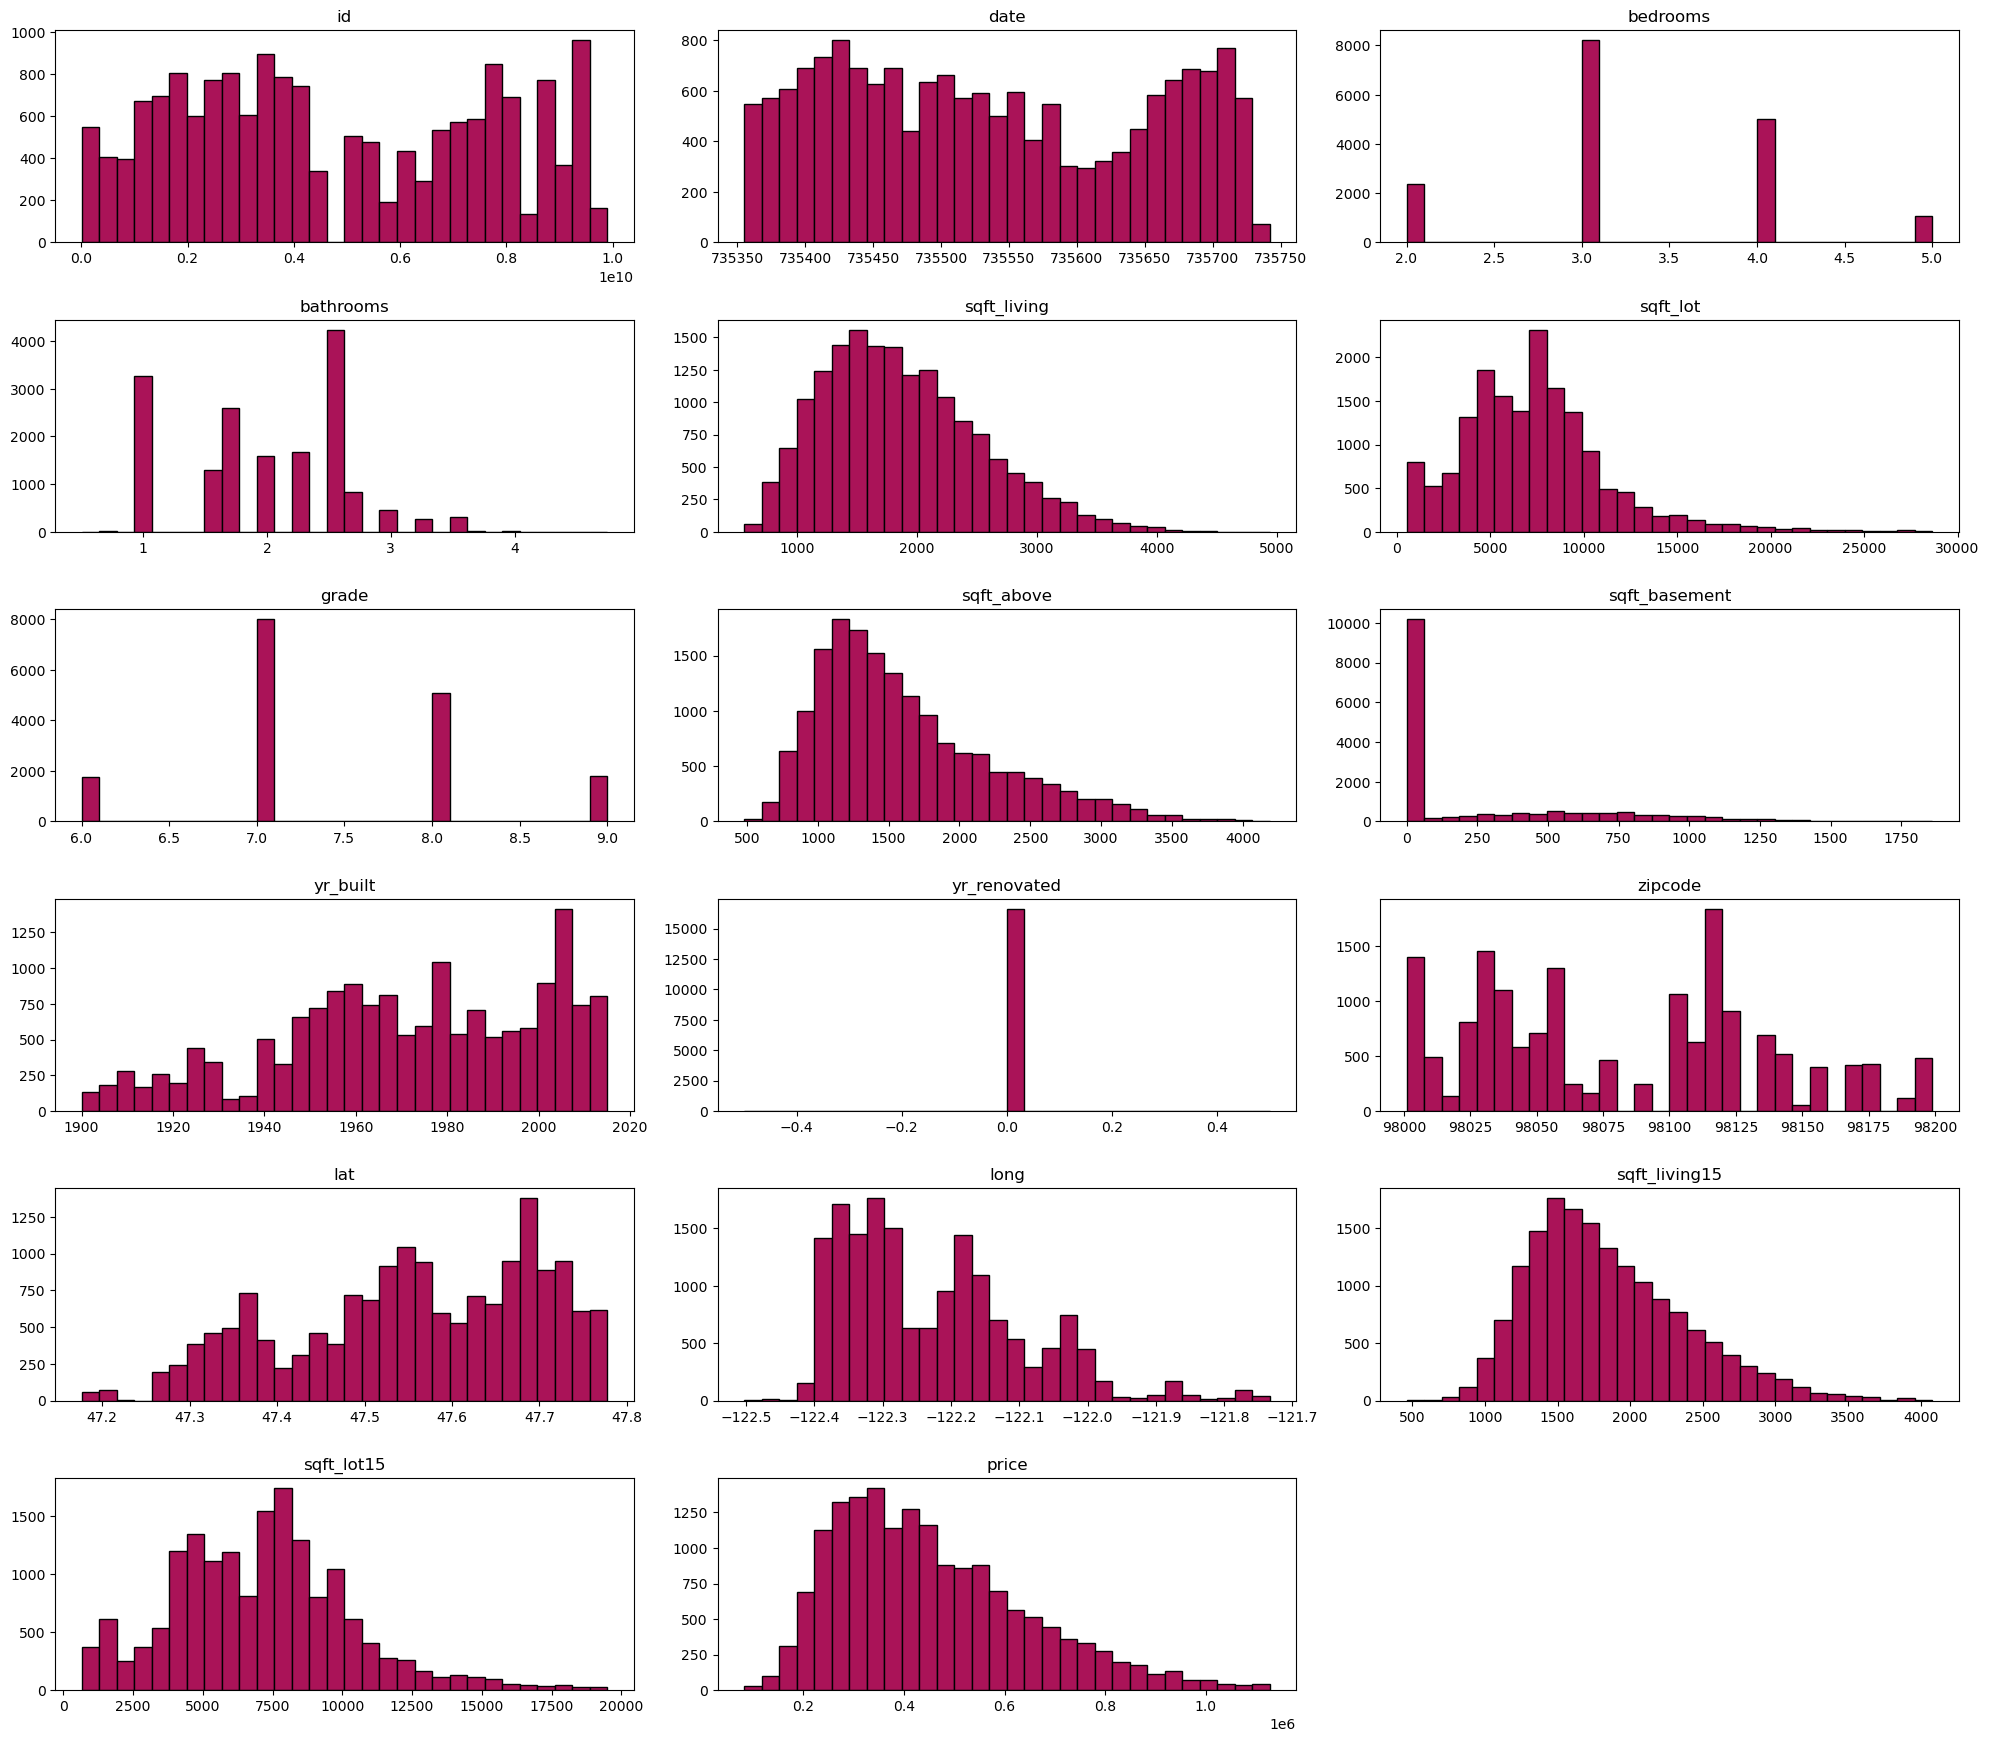

In [8]:
#checking one more time distributions, after dealing w/ outliers

color = '#0072B2'

# grid size
nrows, ncols = 7, 3  # adjust for your number of features

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(df_wo_out.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(df_wo_out.iloc[:, i], bins=30, color="#AA1358", edgecolor='black')
    ax.set_title(df_wo_out.columns[i])

plt.tight_layout()
plt.show()

<h3 style="color: #A4064D;">Dropping Columns post normalization</h3>

- Checking distributions after dealing w/ outliers give us **insights to do new columns' drop**

In [9]:
df_wo_out["bedrooms"].value_counts()

bedrooms
3    8217
4    4998
2    2351
5    1056
Name: count, dtype: int64

In [10]:
df_wo_out["yr_renovated"].value_counts()

yr_renovated
0    16622
Name: count, dtype: int64

In [11]:
df_wo_out["grade"].value_counts()

grade
7    8003
8    5077
9    1798
6    1744
Name: count, dtype: int64

- Although "bedrooms" and "degrees" have only a few counts, we suspect that they might be necessary for the model.

In [12]:
columns_to_delete = ["yr_renovated"]

In [13]:
df_wo_out.drop(columns=columns_to_delete, inplace=True)

<h2 style="color: #6D183F;">Improving the Model</h2>


<h3 style="color: #A4064D;">Correlation between variables | Heatmap Multicollinearity</h3>

In [14]:
df_wo_out.corrwith(df_wo_out["price"]).sort_values(ascending=False)

price            1.000000
grade            0.543178
sqft_living      0.540773
sqft_living15    0.486816
lat              0.469985
sqft_above       0.413622
bathrooms        0.363664
sqft_basement    0.255224
bedrooms         0.254389
id               0.036672
zipcode          0.010715
long             0.010462
date             0.005493
yr_built        -0.018760
sqft_lot        -0.042096
sqft_lot15      -0.057220
dtype: float64

In [15]:
df_wo_out_corr = round(df_wo_out.corr(), 2)

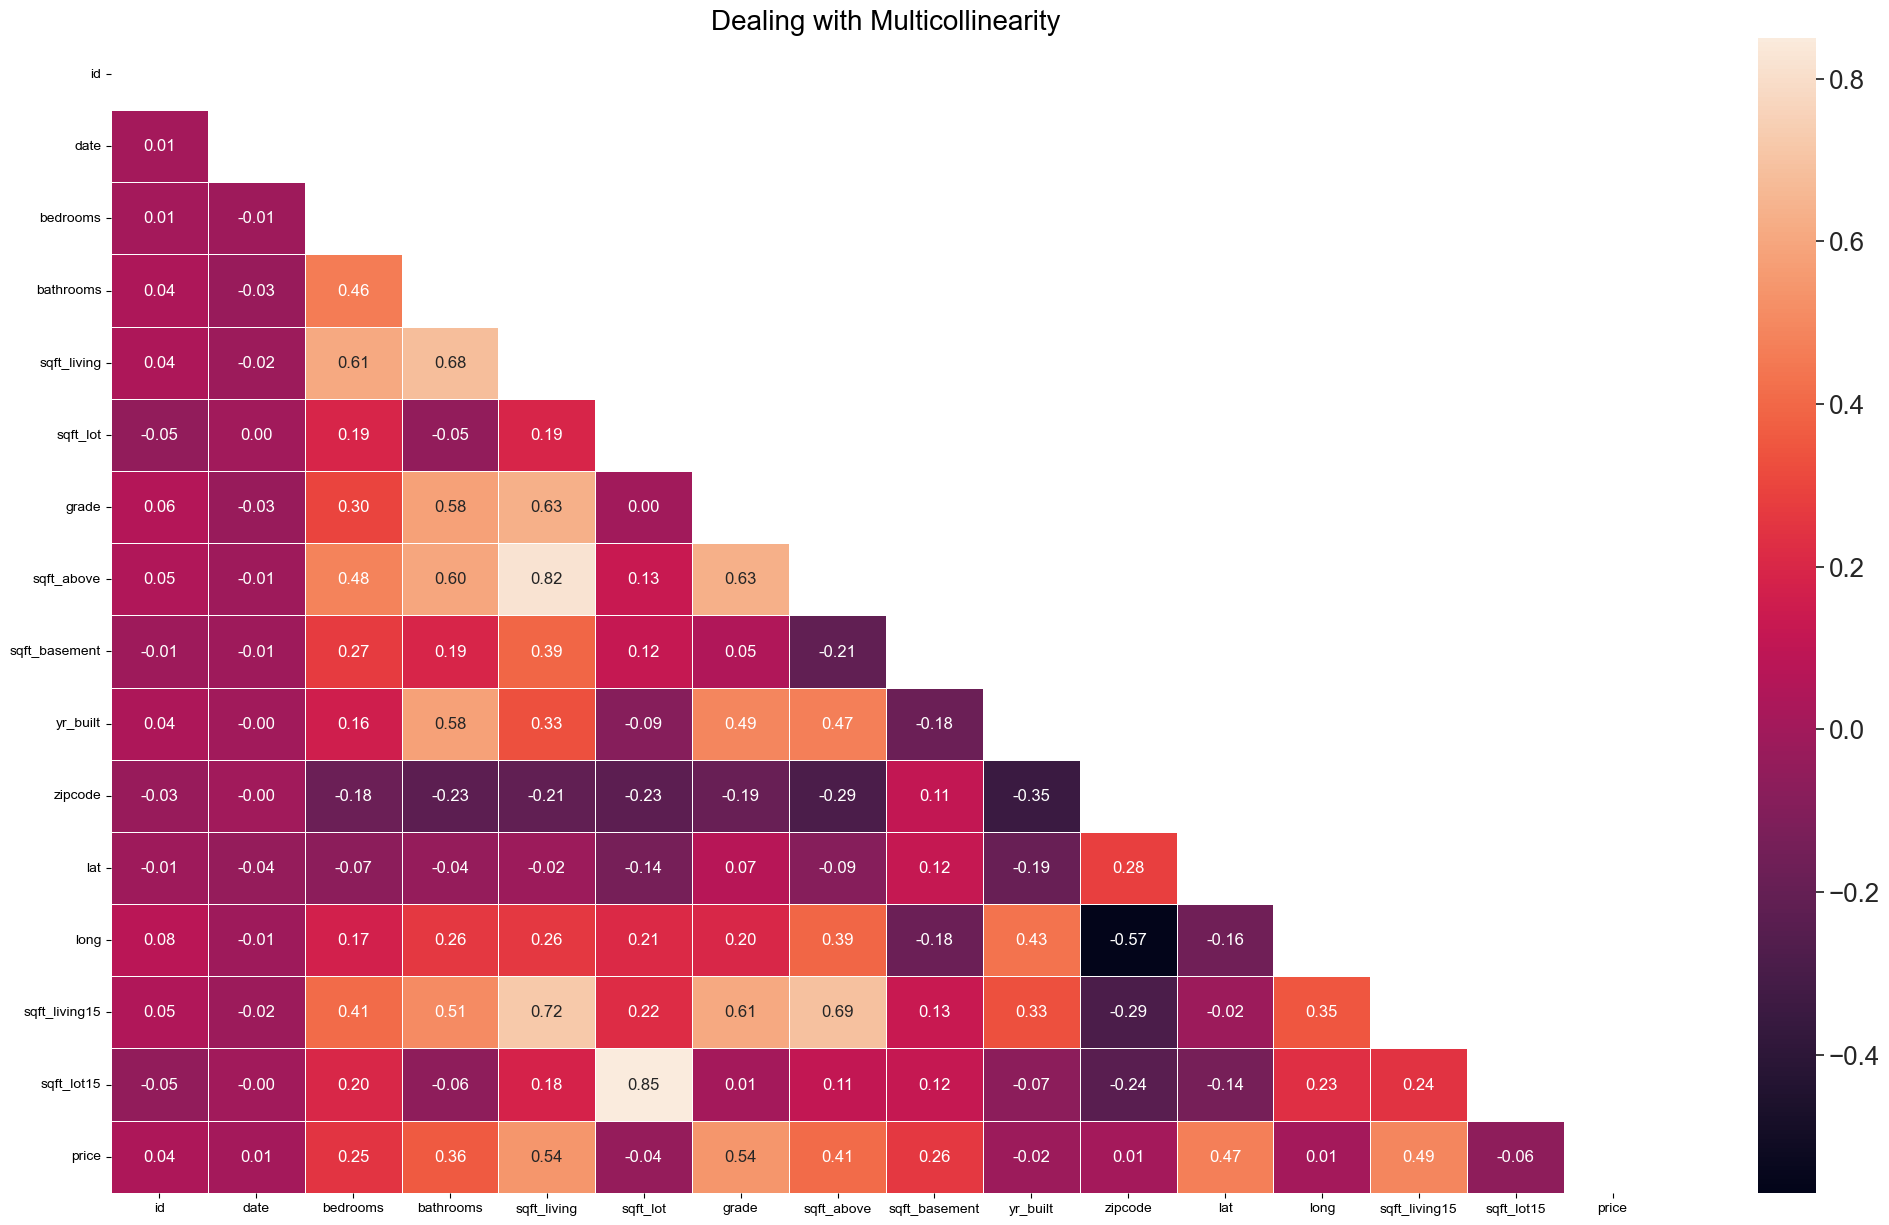

In [16]:
mask = np.zeros_like(df_wo_out_corr)
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.7) 

ax = sns.heatmap(df_wo_out_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="rocket", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) 
plt.show()

- Now it's time to use the scissors! We will determinate variables to drop for **their nature** (we saw before that **id** and **data** are uniform) or their **correlation between them**.

In [17]:
df_wo_out.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [18]:
# Explore the heatmap to eliminate the variables correlated between them

columns_to_delete2 = ["id","date", "zipcode", "sqft_lot","sqft_above","sqft_basement"]

In [19]:
df_wo_out = df_wo_out.drop(columns=columns_to_delete2)

In [20]:
df_wo_out_corr = round(df_wo_out.corr(), 2)

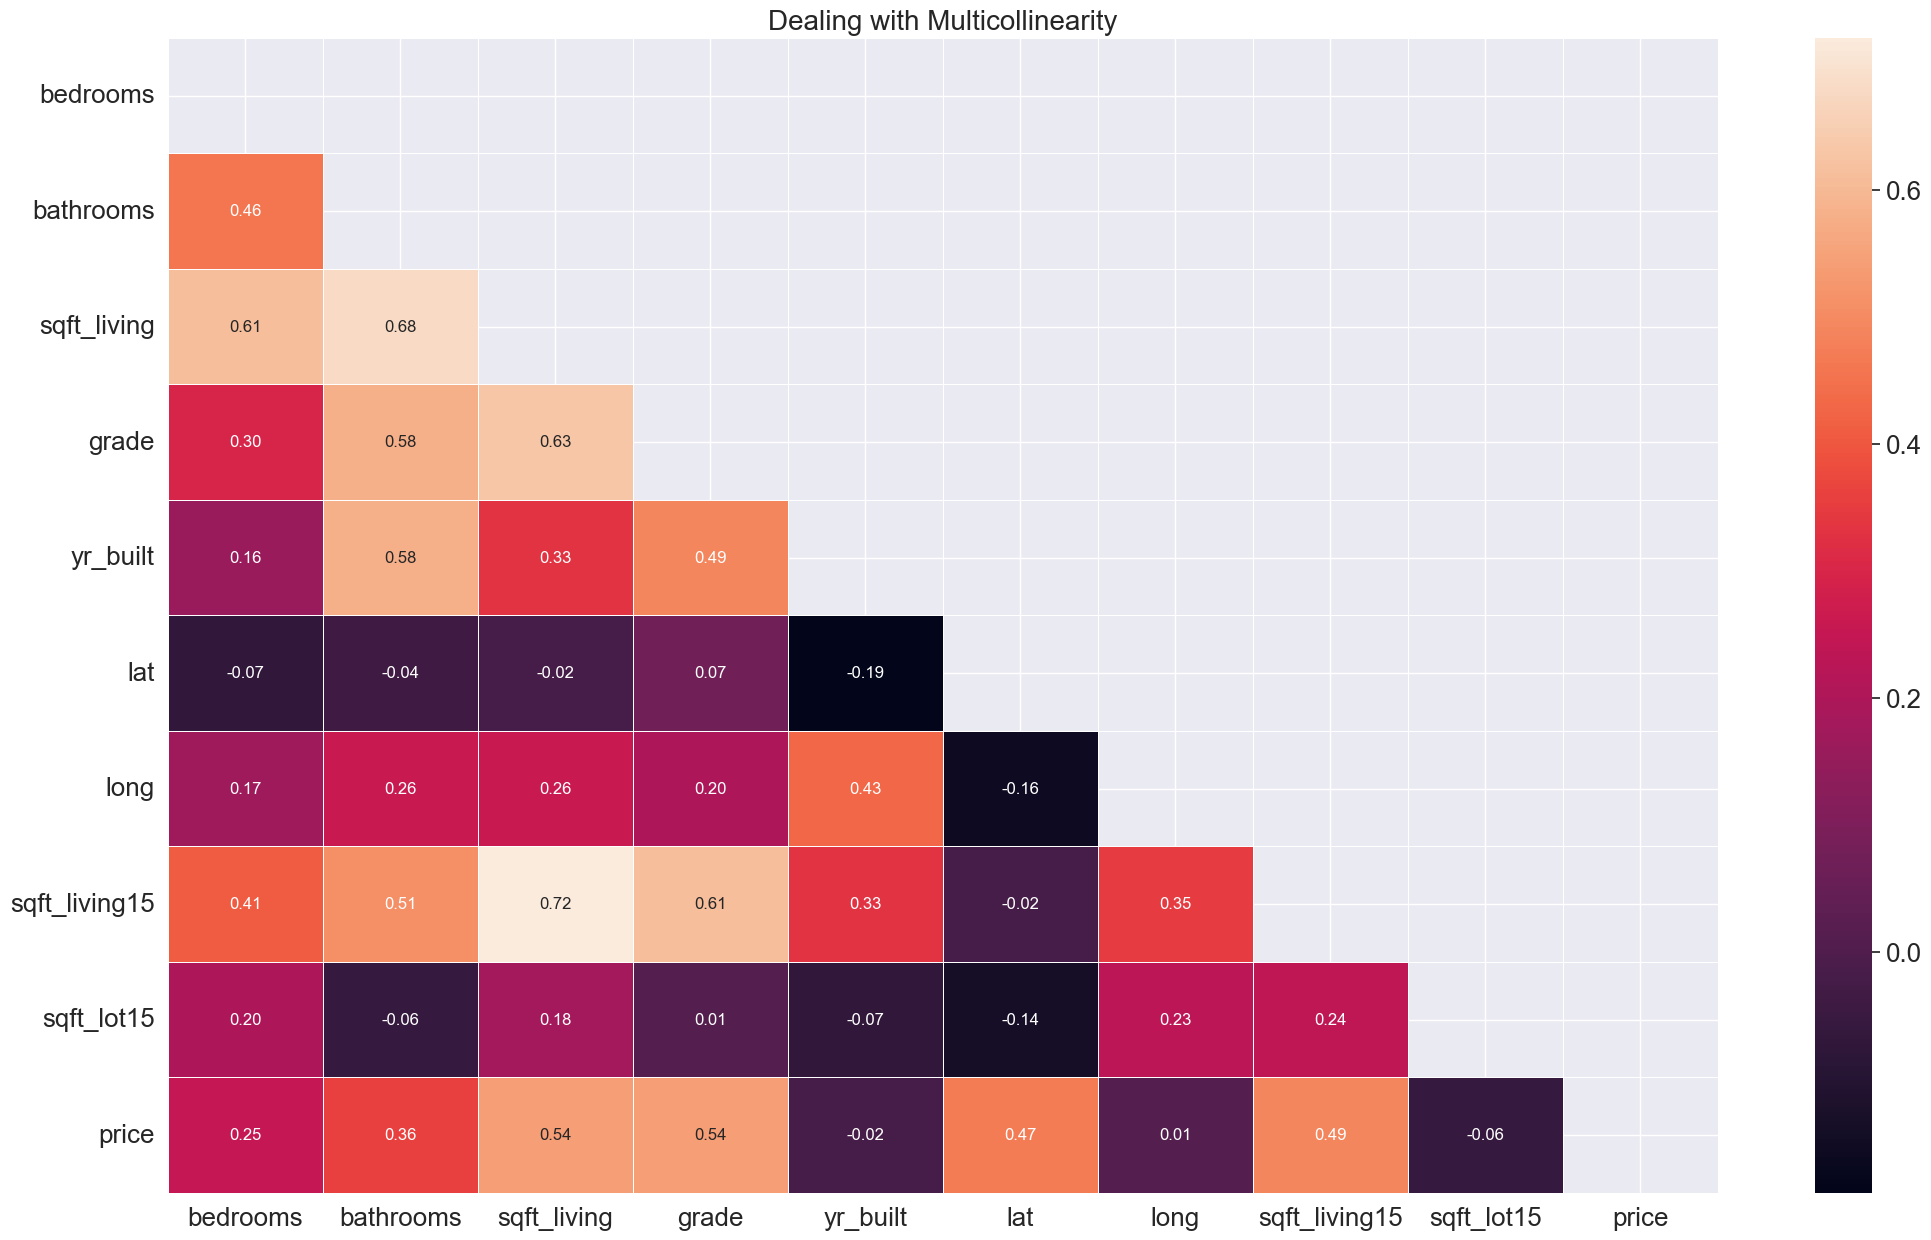

In [21]:
mask = np.zeros_like(df_wo_out_corr)
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.7) 

ax = sns.heatmap(df_wo_out_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="rocket", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) 
plt.show()

<h3 style="color: #A4064D;">Selecting the model: XGBoost Regresion</h3> 

- In the previous notebook we decide to **use XGBoost after their good metrics**. So now we will split and train our data recently treated and try to make a good predictor model.

In [22]:
X = df_wo_out.drop("price", axis=1)
y = df_wo_out["price"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

<h3 style="color: #A4064D;">Normalization with MinMaxScaler</h3> 

- We already normalize the outliers, but lets do another preprocessing step: normalize through MinMaxScaler

In [24]:
from sklearn.preprocessing import MinMaxScaler 

In [25]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
xgbr = xgb.XGBRFRegressor()
xgbr.fit(X_train_scaled, y_train) #Aqui X_train escalado

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

- Model validation

In [27]:
predictions_xgb = xgbr.predict(X_test_scaled)

- Metrics

In [28]:
r2_xgb = r2_score(y_test, predictions_xgb)
RMSE_xgb = mean_squared_error(y_test, predictions_xgb, squared=False)
MSE_xgb = mean_squared_error(y_test, predictions_xgb)
MAE_xgb = mean_absolute_error(y_test, predictions_xgb)

In [29]:
print("R2 = ", round(r2_xgb, 4))
print("RMSE = ", round(RMSE_xgb, 4))
print("The value of the metric MSE is ", round(MSE_xgb, 4))
print("MAE = ", round(MAE_xgb, 4))

R2 =  0.7893
RMSE =  84996.5993
The value of the metric MSE is  7224421897.1575
MAE =  61753.4755


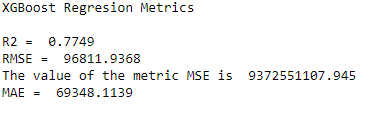

- Our final results **doesn't improve to much** from the **default XGBoost model**

<h2 style="color: #6D183F;">Testing Target vs Prediction</h2>


In [30]:
series_pred = pd.Series(predictions_xgb, name='predictions')

In [31]:
series_y_test = pd.Series(y_test, name='actual')

In [32]:
comparison_df = pd.concat([series_y_test.reset_index(drop=True), series_pred], axis=1)

In [33]:
comparison_df.head(10)

,actual,predictions
0,420000.0,401122.625000
1,325000.0,331800.937500
2,668500.0,613711.125000
3,325000.0,446587.843750
4,675000.0,668451.875000
5,630000.0,360333.687500
6,545000.0,605003.062500
7,535000.0,533837.000000
8,425000.0,469445.468750
9,189950.0,205019.546875


In [34]:
comparison_percent_df = comparison_df.copy()

- Comparision percentage between target and prediction

In [35]:
for index, row in comparison_df.iterrows():
    if row["actual"] < row["predictions"]:
        comparison_percent_df.at[index, "percent_dif"] = ((row["predictions"] - row["actual"]) / row["actual"]) * 100
    else:
        comparison_percent_df.at[index, "percent_dif"] = ((row["actual"] - row["predictions"]) / row["actual"]) * 100

In [36]:
comparison_percent_df.round(2).sample(10)

,actual,predictions,percent_dif
2482,411100.0,436404.62500,6.16
1011,273000.0,285650.06250,4.63
1000,465000.0,315800.65625,32.09
1904,735000.0,672472.18750,8.51
1394,400000.0,466235.53125,16.56
2450,311000.0,346514.71875,11.42
2329,630100.0,470885.09375,25.27
1427,670000.0,628014.81250,6.27
220,550000.0,558739.37500,1.59
2272,599500.0,577153.62500,3.73


In [37]:
mean_diff = comparison_percent_df["percent_dif"].mean().round(2)
max_diff = comparison_percent_df["percent_dif"].max()
min_diff = comparison_percent_df["percent_dif"].min()
std_diff = comparison_percent_df["percent_dif"].std()

print(f"Comparison mean: {mean_diff}")
print(f"Comparison max: {max_diff}")
print(f"Comparison min: {min_diff}")
print(f"Comparison std deviation: {std_diff}")

Comparison mean: 15.12
Comparison max: 248.54612068965517
Comparison min: 0.0013419117647058825
Comparison std deviation: 16.416971924697584


<h3 style="color: #A4064D;">Final Comparision | EDA</h3> 

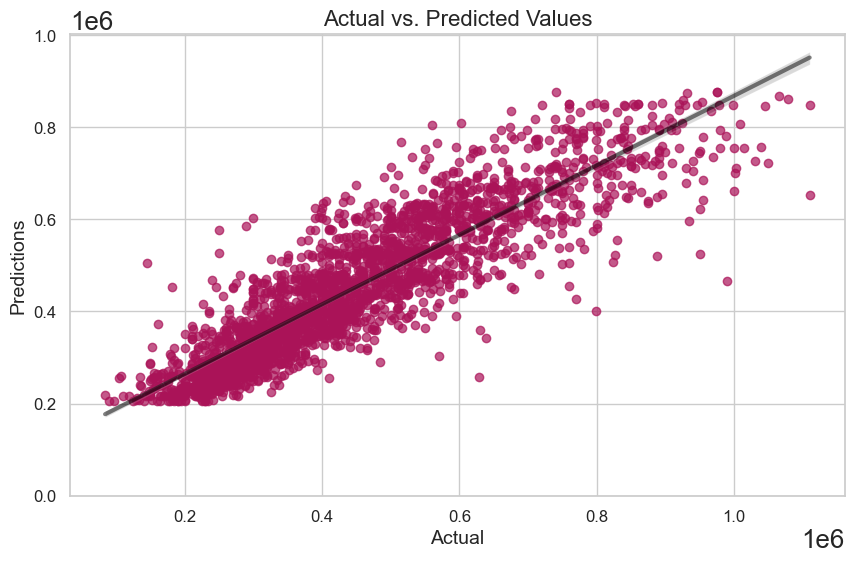

In [38]:
scatter_color = "#AA1358"
line_color = "black"

plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")

sns.regplot(x='actual', y='predictions', data=comparison_df, 
            scatter_kws={"color": scatter_color, "alpha": 0.7},
            line_kws={"color": line_color, "alpha": 0.5, "linewidth": 3})

plt.ylim(bottom=0)
plt.title('Actual vs. Predicted Values', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- After all preprocessing, we still have a model **underfitting the outcomes**. We successed in **improve the R2 a 1%** and **decrease the error metrics**, but that wasn't enough.